<a href="https://colab.research.google.com/github/LeehyeongTea/image_captioning_with_attention/blob/main/evaluation_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Greedy
BLEU-1: 0.6021306502922246
BLEU-2: 0.4124893795271643
BLEU-3: 0.31311506016570884
BLEU-4: 0.1850805389556838
k=3 beam
BLEU-1: 0.6458849456814152
BLEU-2: 0.45004543862095364
BLEU-3: 0.3448907193458137
BLEU-4: 0.20824690025701065
inference
96116736/96112376 [==============================] - 1s 0us/step
['sq', 'a', 'grey', 'dog', 'is', 'jumping', 'over', 'a', 'snowcovered', 'hill', 'eq']
['sq', 'a', 'person', 'is', 'climbing', 'a', 'snowcovered', 'hill', 'eq']


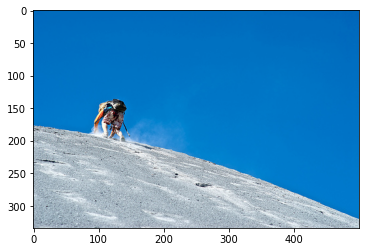

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import h5py
import re
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from nltk.translate.bleu_score import corpus_bleu

import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
def visualization_attention(image, result, attention_plot):
  temp = np.array(image)
  fig = plt.figure(figsize = (10,10))
  
  for i in range(0,len(result)):
    att = np.resize(attention_plot[i],(8,8))
    grid_size = max(np.ceil(len(result)/2),2)
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.set_title(result[i])
    img = ax.imshow(temp)
    ax.imshow(att, cmap='gray',alpha=0.6,extent=img.get_extent())

  plt.tight_layout()
  plt.show()


def make_seq(generate,tokenizer):
  result = list()
  for elem in generate:
    result.append(tokenizer.index_word[elem])
  return result

def create_caption_greedy(decoder, feature, max_len, tokenizer):
  
  attention_plot = np.zeros((max_len,64))
  hidden = tf.zeros((1,512))
  start = [tokenizer.word_index['sq']]
  
  for i in range(max_len):
    seq = pad_sequences([start],maxlen = max_len,padding = 'post')
    output, hidden, attention_dist = decoder([seq,feature,hidden])
    attention_plot[i] = tf.reshape(attention_dist,(-1, )).numpy()
    pred = np.argmax(output)
    
    start.append(pred)
    
    if pred == tokenizer.word_index['eq']:
      return make_seq(start,tokenizer), attention_plot
    
    
  return make_seq(start,tokenizer), attention_plot

def create_caption_beam(model, feature, max_len, tokenizer,k):
  start = 'sq'
  start = tokenizer.texts_to_sequences([start])[0]


  depth_seq=[]
  hidden = tf.zeros((1,512))
  sequences = [[start, 0.0]]
 

  while len(sequences[0][0]) < max_len :
    all_candidate = list()
    depth =1
    for sequence in sequences:
      seq = pad_sequences([sequence[0]],maxlen = max_len,padding = 'post')
      

      output, hidden, _ = decoder([seq,feature,hidden])

      candidate_preds = np.argsort(output[0])[-k:]

      for candidate in candidate_preds: 
        get_cap = sequence[0][:]
        score = sequence[1]
        get_cap.append(candidate)
        score = score+np.log(output[0][candidate]+1e-10)
        if get_cap[-1] == tokenizer.word_index['eq'] :
          #depth만큼 나눠 평균을 구해준다.
          depth_seq.append([get_cap,score/depth])
          continue
        else :  
          all_candidate.append([get_cap,score])

    sequences = all_candidate
    sequences = sorted(sequences, key = lambda I: I[1])
    sequences = sequences[-k:]

  depth_seq = sorted(depth_seq, key = lambda l: l[1])
  depth_seq = depth_seq[-1][0]
  #최고점수 시퀀스 찾음
  result = make_seq(depth_seq,tokenizer)
  return result




def Bleu_Score_Greedy(decoder, seq,sortedList, feature, tokenizer,saved_path, max_len):
  y = list()
  pred = list()

  for elem in sortedList:
    f_arr = np.array(feature[elem][:])
    generated,_ = create_caption_greedy(decoder,f_arr,max_len,tokenizer)
    target_words = list()
    for line in seq[elem]:
      line = line.lower()
      target_words.append(line.split())
    
    y.append(target_words)
    pred.append(generated)

  print("Greedy")
  print('BLEU-1: ' + str(corpus_bleu(y,pred,weights=(1.0,0,0,0))))
  print('BLEU-2: ' + str(corpus_bleu(y,pred,weights=(0.5,0.5,0,0))))
  print('BLEU-3: ' + str(corpus_bleu(y,pred,weights=(0.3,0.3,0.3,0))))
  print('BLEU-4: ' + str(corpus_bleu(y,pred,weights=(0.25, 0.25, 0.25, 0.25))))
  
def Bleu_Score_Beam(decoder, seq,sortedList, feature, tokenizer,saved_path, max_len,k):
  y = list()
  pred = list()

  for elem in sortedList:
    f_arr = np.array(feature[elem][:])
    generated = create_caption_beam(decoder,f_arr,max_len,tokenizer,k)
    target_words = list()
    for line in seq[elem]:
      line = line.lower()
      target_words.append(line.split())
    
    y.append(target_words)
    pred.append(generated)

  print("k=3 beam")
  print('BLEU-1: ' + str(corpus_bleu(y,pred,weights=(1.0,0,0,0))))
  print('BLEU-2: ' + str(corpus_bleu(y,pred,weights=(0.5,0.5,0,0))))
  print('BLEU-3: ' + str(corpus_bleu(y,pred,weights=(0.3,0.3,0.3,0))))
  print('BLEU-4: ' + str(corpus_bleu(y,pred,weights=(0.25, 0.25, 0.25, 0.25))))
  


def inference(decoder, img_path, tokenizer,max_len,test_list,k):
  print("inference")
  get_CNN = InceptionV3()
  CNN_model = Model(inputs=get_CNN.input, outputs=get_CNN.layers[-3].output)

  img_file = os.path.join(img_path,test_list[20])
  loaded_img = Image.open(img_file, 'r')

  temp = loaded_img
  imshow(np.asarray(temp))
  loaded_img = image.load_img(img_file, target_size = (299, 299))
  loaded_img = image.img_to_array(loaded_img)
  loaded_img = preprocess_input(loaded_img)
  loaded_img = np.expand_dims(loaded_img, 0)
  feature = CNN_model.predict(loaded_img)
  feature = tf.reshape(feature, (feature.shape[0],-1,feature.shape[3]))
  
  result, attention_plot = create_caption_greedy(decoder,feature,max_len,tokenizer)
  #visualization_attention(temp,result,attention_plot)
  print(result)
  print(create_caption_beam(decoder,feature,max_len,tokenizer,3))


if __name__ == '__main__':
  
  base_directory = '/content/gdrive/My Drive/Colab Notebooks/image_captioning_with_attention'
  saved_data_path = os.path.join(base_directory,'data')
  saved_model_path = os.path.join(base_directory,'merge_model','saved_model')
  data_base_directory ='/content'
  img_data_directory = os.path.join(data_base_directory,'flickr8k_dataset','Flicker8k_Dataset')



  saved_path = os.path.join(base_directory, 'data')
  data_h5_paths = os.path.join(saved_data_path, 'needs.hdf5')
  needs = h5py.File(data_h5_paths, 'r')

  test_dataset_list_path = needs['test_code_path'][()]
  
  test_feature_path = needs['test_feature_path'][()]

  test_seq_path_X = needs['test_seq_path'][()]

  
  tokenpath = needs['token_path'][()]
  max_len = needs['max_len'][()]
  vocab_size= needs['vocab_size'][()]
  
  req_token_path = needs['req_token_path'][()]
  req_test_list_path = needs['req_test_list_path'][()]
  req_seq_path = needs['req_seq_path'][()]
  
  decoder_path = os.path.join(saved_model_path,'decoder_model_13_vacc_0.797_vloss_1.076_acc0.819_loss0.812.h5')

  with open(req_token_path, 'rb') as handle:
    tokenizer = pickle.load(handle)
  with open(req_test_list_path, 'rb') as handle:
    test_list = pickle.load(handle)
  with open(req_seq_path, 'rb') as handle:
    sequence = pickle.load(handle)


  decoder = load_model(decoder_path,compile=False)
  
  with h5py.File(test_feature_path,'r') as hf:
    Bleu_Score_Greedy(decoder, sequence, test_list, hf, tokenizer,saved_path, max_len)
    Bleu_Score_Beam(decoder,sequence,test_list,hf,tokenizer,saved_path,max_len,3)
  
  inference(decoder, img_data_directory, tokenizer,max_len,test_list,3)    